# Projet ARF : inpainting 
##### TREÜ Marc ; KARMIM Yannis

### Préambule : régression linéaire, régression ridge et LASSO

In [117]:
import sys, os
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

import numpy as np
import math
import sklearn
from sklearn.linear_model import LinearRegression,Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing


def load_usps(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)


# Chargement des données USPS. 

trainX, trainY = load_usps('data/USPS_train.txt')
testX, testY = load_usps('data/USPS_test.txt')

#### Regression Linéaire

In [2]:
def fit_linear_regression(n1,n2,dataX,dataY):
    
    """Compare deux classes représentant les nombres n1 et n2
    en utilisant une régression linéaire ."""

    indice_classe = np.where(np.in1d(dataY, [n1,n2]))
    X = dataX[indice_classe]
    Y = np.where(dataY[indice_classe] == n1, 1, -1)

    return LinearRegression(normalize=True).fit(X,Y)

In [3]:
# Choix des classes : 
n1 = 1
n2 = 7

reg = fit_linear_regression(n1,n2,trainX,trainY)

indice_classe = np.where(np.in1d(testY, [n1,n2]))
X_test = testX[indice_classe]
Y_test = np.where(testY[indice_classe] == n1, 1, -1)

Score calculer avec le coeficient de determination R²

In [4]:
reg.score(X_test, Y_test)

-5.4150241635465626e+19

Score calculé avec la methode plug-in

In [5]:
np.sum(np.sign(reg.predict(X_test)) == Y_test) / len(Y_test)

0.9708029197080292

In [6]:
def plugin_score(models, X_test, Y_test):
    return np.sum(np.sign(models.predict(X_test)) == Y_test) / len(Y_test)

#### Ridge Regression ( sans Cross Val ) 

In [7]:
def fit_ridge_regression(n1,n2,dataX,dataY,alpha=1.0):
    """Compare deux classes représentant les nombres n1 et n2
    en utilisant une Ridge Regression."""
    
    indice_classe = np.where(np.in1d(dataY, [n1,n2]))
    X = dataX[indice_classe]
    Y = np.where(dataY[indice_classe] == n1, 1, -1)

    return Ridge(alpha=alpha).fit(X,Y)

ridge = fit_ridge_regression(n1,n2,trainX,trainY,alpha=1.0)
print("score avec la ridge regression :", plugin_score(ridge, X_test, Y_test))

score avec la ridge regression : 0.9878345498783455


#### Ridge Regression ( avec Cross Val )

In [8]:
def fit_ridge_regressionCV(n1,n2,dataX,dataY,nb_cv = 10, verbose=False):
    """Compare deux classes représentant les nombres n1 et n2
    en utilisant une Ridge Regression avec Cross Val."""
    
    indice_classe = np.where(np.in1d(dataY, [n1,n2]))
    X = dataX[indice_classe]
    Y = np.where(dataY[indice_classe] == n1, 1, -1)
    
    clf = RidgeCV(alphas=(0.1, 1, 5, 10, 20), cv = nb_cv)
    clf.fit(X,Y)
    
    if verbose:
        print("Meilleur alpha trouvé par Cross Validation : ",clf.alpha_)
    
    return clf 

ridgeCV = fit_ridge_regressionCV(n1, n2, trainX, trainY, verbose=True)
print("score avec la ridge regression + cross validation :",plugin_score(ridgeCV, X_test, Y_test))

Meilleur alpha trouvé par Cross Validation :  20.0
score avec la ridge regression + cross validation : 0.9854014598540146


#### LASSO 

In [9]:
def fit_LASSO(n1,n2,dataX,dataY,alpha = 0.001):
    """Compare deux classes représentant les nombres n1 et n2
    en utilisant une Ridge Regression avec Cross Val."""
    
    indice_classe = np.where(np.in1d(dataY, [n1,n2]))
    X = dataX[indice_classe]
    Y = np.where(dataY[indice_classe] == n1, 1, -1)
    clf = Lasso(alpha = alpha)
    clf.fit(X,Y)
    
    return clf 

lasso = fit_LASSO(n1,n2,trainX,trainY,alpha=0.1)
print("score avec lasso regression :", plugin_score(lasso, X_test, Y_test))

score avec lasso regression : 0.9635036496350365


#### LASSO + Cross Validation

In [10]:
def fit_LASSO_CV(n1,n2,dataX,dataY,nb_cv = 10, verbose=False):
    """Compare deux classes représentant les nombres n1 et n2
    en utilisant une Ridge Regression avec Cross Val."""
    
    indice_classe = np.where(np.in1d(dataY, [n1,n2]))
    X = dataX[indice_classe]
    Y = np.where(dataY[indice_classe] == n1, 1, -1)
    
    clf = LassoCV(cv = nb_cv)
    clf.fit(X,Y)
    if verbose:
        print("Meilleur alpha trouvé par Cross Validation : ",clf.alpha_)
    
    return clf 

lassoCV = fit_LASSO_CV(n1, n2, trainX, trainY, verbose=True)
print("score avec lasso regression + cross validation :",plugin_score(lassoCV, X_test, Y_test))

Meilleur alpha trouvé par Cross Validation :  0.0014878791090701493
score avec lasso regression + cross validation : 0.9829683698296837


In [11]:
import itertools

def calcule_all_result(trainX, trainY, testX, testY):
    
    # Combinaison de tous les classifieur classe i vs classe j : [(1, 2), (1, 3), ...]
    combinaison = [i for i in itertools.combinations([(j) for j in range(10)], 2)]
    
    # On fit les 5 models pour chaque classe i vs classe j
    models_regression = [fit_linear_regression(n[0], n[1], trainX, trainY) for n in combinaison]
    
    models_ridge = [fit_ridge_regression(n[0], n[1], trainX, trainY) for n in combinaison]
    models_ridgeCV = [fit_ridge_regressionCV(n[0], n[1], trainX, trainY) for n in combinaison]
    
    models_lasso = [fit_LASSO(n[0],n[1], trainX, trainY) for n in combinaison]
    models_lassoCV = [fit_LASSO_CV(n[0],n[1], trainX, trainY) for n in combinaison]
    
    models = [models_regression, models_ridge, models_ridgeCV, models_lasso, models_lassoCV]
    
    score_models_regression = []
    score_models_ridge = []
    score_models_ridgeCV = []
    score_models_lasso = []
    score_models_lassoCV = [] 
    
    for n in range(len(combinaison)):
        n1, n2 = combinaison[n]
        indice_classe = np.where(np.in1d(testY, [n1,n2]))
        X = testX[indice_classe]
        Y = np.where(testY[indice_classe] == n1, 1, -1)
        
        score_models_regression.append(plugin_score(models_regression[n], X, Y))
        score_models_ridge.append(plugin_score(models_ridge[n], X, Y))
        score_models_ridgeCV.append(plugin_score(models_ridgeCV[n], X, Y))
        score_models_lasso.append(plugin_score(models_lasso[n], X, Y))
        score_models_lassoCV.append(plugin_score(models_lassoCV[n], X, Y))

    scores = [score_models_regression, score_models_ridge, score_models_ridgeCV, score_models_lasso, score_models_lassoCV] 
    
    return models, scores

In [12]:
models, scores = calcule_all_result(trainX, trainY, testX, testY)

KeyboardInterrupt: 

In [13]:
def calcule_w_moyen(liste_modele):
    return sum(sum(abs(w) for w in liste_modele[i].coef_) / 256 for i in range(len(liste_modele))) / len(liste_modele)

def calcule_w_var(liste_modele):
    return np.var([[w for w in liste_modele[i].coef_ ] for i in range(len(liste_modele))])
    
def calcule_nombre_w_null(liste_modele):
    return sum(len(np.where(liste_modele[i].coef_ == 0)[0]) for i in range(len(liste_modele))) / len(liste_modele)

def calcule_score_moy(liste_score):
    return sum(liste_score) / len(liste_score)
    
def calcule_all(modeles, scores):
    return calcule_score_moy(scores), calcule_w_moyen(modeles), calcule_w_var(modeles), calcule_nombre_w_null(modeles)

                            

In [14]:
resultat_reg = calcule_all(models[0], scores[0])
resultat_ridge = calcule_all(models[1], scores[1])
resultat_ridgeCV = calcule_all(models[2], scores[2])
resultat_lasso = calcule_all(models[3], scores[3])
resultat_lassoCV = calcule_all(models[4], scores[4])

resultat_all = [calcule_all(models[i], scores[i]) for i in range(5)]

def print_resultat(resultat):
    nom_reg = {0:"Regression simplement avec MSE", 1:"Regression avec regularisation l2 (Ridge)", 2:"Regression avec regularisation l2 + cross validation"
    ,3:"Regression avec regularisation l1 (Lasso)",4:"Regression avec regularisation l1 (Lasso) + cross validation"}
    
    for i in range(5):
        print(nom_reg[i],":\n\t\tscore moyenne =", resultat[i][0], "\n\t\tpoid moyen des w =", resultat[i][1]
              , "\n\t\tvariance moyenne des w =", resultat[i][2], "\n\t\tnombre moyen de w a 0 =", resultat[i][3], "\n")


NameError: name 'models' is not defined

### Résultat

In [15]:
print_resultat(resultat_all)

NameError: name 'print_resultat' is not defined

Tous les modèles ont des performances similaire, c'est à dire au alentour de 97% de bonne classification,
mais c'est avec les poids de W apris que la différence est la plus flagrante. Alors que l'on a un W moyenne a 500 millard avec une variance en 10^26 pour la regression sans pénalisation. On tombe à un W moyen inferieur a 0.1 et une variance inferieur a 0.01 pour les normes L1 et L2.

Aussi, l'avantage pricipal de la regularisation Lasso par rapport à Ridge est le nombre de composante W qui devienne nulle, ainsi on a en moyenne 143 W qui devienne egale à 0, sur nos 256 dimension cela represente près de 55% pixels qu'on ne prend plus en consideration pour la classification. La matrice des poids pour Lasso est donc beaucoup plus sparce


### LASSO et Inpainting

##### Fonction preliminaire

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

NOISE = -100

def read_im(fn):
    im = plt.imread(fn)
    return rgb_to_hsv(im)

def show_im(fn):
    
    im = fn.copy()
    im[im == NOISE] = 0
    plt.imshow(hsv_to_rgb(im))
    
def get_patch(i,j,h,im):
    
    start_i = max(0, i - h)
    end_i = min(im.shape[0], i + h + 1)
    start_j = max(0, j - h)
    end_j = min(im.shape[1], j + h + 1)
        
    return im[start_i: end_i, start_j: end_j,:]

def get_pos_in_patch(i, j, h, im):
    pos_i = i if (i - h) < 0 else h
    pos_j = j if (j - h) < 0 else h
    return pos_i, pos_j

def noise(im, p, h=20):
    
    coordonnee_pixels = np.array([np.array((i,j)) for i in range(h,im.shape[0] - h) for j in range(h,im.shape[1]-h)])
    masque = np.random.choice(len(coordonnee_pixels), size=int(len(coordonnee_pixels) * p), replace=False) 
    
    im_res = im.copy()
    
    for noise_pixels in coordonnee_pixels[masque]:
        im_res[noise_pixels[0], noise_pixels[1]] = (NOISE, NOISE, NOISE)
    
    return im_res

def delete_rect(im, i, j, h, w):
    
    im_res = im.copy()
    im_res[i: i + h, j: j + w] = (NOISE, NOISE, NOISE)
    
    return im_res

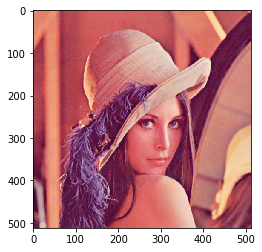

In [72]:
lena = read_im('data/lena.png')
show_im(lena)

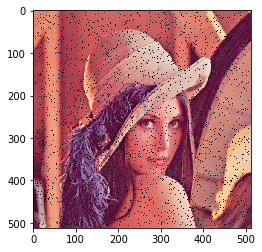

In [73]:
show_im(noise(lena,0.05,5))

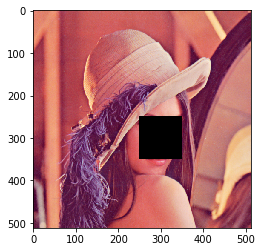

In [74]:
show_im(delete_rect(lena,250,250,100,100))

Nous avons definie les fonctions de bruitage, nous allons a présent definir les fonctions qui recupérer les patch bruité ou non de l'image

In [75]:
def get_all_patch(im, h, step):
    
    coordonne_centre_patch = np.array([np.array((i, j)) for i in range(h, im.shape[0] - h, step) \
                                       for j in range(h, im.shape[1] - h, step)])
    return np.array([get_patch(i, j, h, im) for (i, j) in coordonne_centre_patch])

def get_all_noise_path(im, h, step):
    return np.array([patch for patch in get_all_patch(im, h, step) if NOISE in patch])

def get_all_clear_path(im, h, step):
    return np.array([patch for patch in get_all_patch(im, h, step) if NOISE not in patch])

def patch_to_vect(patch):
    return patch.reshape(-1)

def vect_to_patch(vect):
    h = int((vect.shape[0]/3)**(0.5))
    return vect.reshape(h,h,3)

def get_next_pixel_to_fill(im,ind=0):
    masque = np.where(im == NOISE)
    return masque[0][0], masque[1][0]

def get_pixel_to_fill(im):
    masque = np.where(im == NOISE)
    return masque[0], masque[1]


#### 2.2 Si l'on a du bruit dans l'image

In [156]:
def inpainting_bruit(im, h, step, alpha=0.001, max_iter=100):
    
    im_res = im.copy()
        
    pixels_to_fill = get_pixel_to_fill(im_res)
    
    liste_patch_clear = get_all_clear_path(im, h, step)
    dictionnaireh = np.array([patch_to_vect(patch[:,:,0]) for patch in liste_patch_clear])
    dictionnaires = np.array([patch_to_vect(patch[:,:,1]) for patch in liste_patch_clear])
    dictionnairev = np.array([patch_to_vect(patch[:,:,2]) for patch in liste_patch_clear])
    
    modelh = sklearn.linear_model.Lasso(alpha=alpha, max_iter=max_iter)
    models = sklearn.linear_model.Lasso(alpha=alpha, max_iter=max_iter)
    modelv = sklearn.linear_model.Lasso(alpha=alpha, max_iter=max_iter)
    
    for p in range(0,len(pixels_to_fill[0]),3):
        
        print(len(pixels_to_fill[0]) - p)
        pixel = [pixels_to_fill[0][p], pixels_to_fill[1][p]]
        patch = get_patch(*pixel, h, im_res)

        patchh = patch_to_vect(patch[:,:,0])
        patchs = patch_to_vect(patch[:,:,1])
        patchv = patch_to_vect(patch[:,:,2])
        masqueh = np.where(patchh != NOISE)
        masques = np.where(patchs != NOISE)
        masquev = np.where(patchv != NOISE)

        modelh.fit(dictionnaireh.T[masqueh], patchh[masqueh])
        
        models.fit(dictionnaires.T[masques], patchs[masques])
    
        modelv.fit(dictionnairev.T[masquev], patchv[masquev])
        
        i, j = get_pos_in_patch(pixel[0],pixel[1], h, im)
        t = i * (2 * h + 1) + j
        patchh[t] = modelh.predict(dictionnaireh[:,t].T.reshape(1, -1))
        patchs[t] = models.predict(dictionnaires[:,t].T.reshape(1, -1))
        patchv[t] = modelv.predict(dictionnairev[:,t].T.reshape(1, -1))
                
        im_res[pixel[0], pixel[1]] = np.array((patchh[t],patchs[t],patchv[t]))
        
    return im_res
        


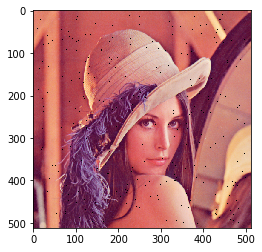

In [157]:
l2 = noise(lena,0.005,10)

show_im(l2)


3630
True
3627
True
3624
True
3621
True
3618
True
3615
True
3612
True
3609
True
3606
True
3603
True
3600
True
3597
True
3594
True
3591
True
3588
True
3585
True
3582
True
3579
True
3576
True
3573
True
3570
True
3567
True
3564
True
3561
True
3558
True
3555
True
3552
True
3549
True
3546
True
3543
True
3540
True
3537
True
3534
True
3531
True
3528
True
3525
True
3522
True
3519
True
3516
True
3513
True
3510
True
3507
True
3504
True
3501
True
3498
True
3495
True
3492
True
3489
True
3486
True
3483
True
3480
True
3477
True
3474
True
3471
True
3468
True
3465
True
3462
True
3459
True
3456
True
3453
True
3450
True
3447
True
3444
True
3441
True
3438
True
3435
True
3432
True
3429
True
3426
True
3423
True
3420
True
3417
True
3414
True
3411
True
3408
True
3405
True
3402
True
3399
True
3396
True
3393
True
3390
True
3387
True
3384
True
3381
True
3378
True
3375
True
3372
True
3369
True
3366
True
3363
True
3360
True
3357
True
3354
True
3351
True
3348
True
3345
True
3342
True
3339
True
3336
True
3333
True


1170
True
1167
True
1164
True
1161
True
1158
True
1155
True
1152
True
1149
True
1146
True
1143
True
1140
True
1137
True
1134
True
1131
True
1128
True
1125
True
1122
True
1119
True
1116
True
1113
True
1110
True
1107
True
1104
True
1101
True
1098
True
1095
True
1092
True
1089
True
1086
True
1083
True
1080
True
1077
True
1074
True
1071
True
1068
True
1065
True
1062
True
1059
True
1056
True
1053
True
1050
True
1047
True
1044
True
1041
True
1038
True
1035
True
1032
True
1029
True
1026
True
1023
True
1020
True
1017
True
1014
True
1011
True
1008
True
1005
True
1002
True
999
True
996
True
993
True
990
True
987
True
984
True
981
True
978
True
975
True
972
True
969
True
966
True
963
True
960
True
957
True
954
True
951
True
948
True
945
True
942
True
939
True
936
True
933
True
930
True
927
True
924
True
921
True
918
True
915
True
912
True
909
True
906
True
903
True
900
True
897
True
894
True
891
True
888
True
885
True
882
True
879
True
876
True
873
True
870
True
867
True
864
True
861
True
858
Tru

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


27
True
24
True
21
True
18
True
15
True
12
True
9
True
6
True
3
True


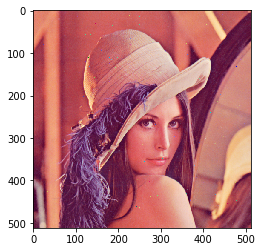

In [158]:
t = inpainting_bruit(l2,5,10,alpha=0.0001,max_iter=10)
show_im(t)

In [143]:
m=np.where(t>1)
m

(array([ 10,  28,  31,  35,  45,  45,  50,  57,  58,  64,  67,  72,  76,
         91,  96, 106, 133, 140, 146, 161, 161, 168, 169, 171, 178, 182,
        195, 205, 207, 213, 221, 245, 256, 267, 268, 271, 272, 275, 276,
        282, 282, 284, 284, 293, 296, 298, 301, 307, 325, 327, 328, 343,
        346, 355, 368, 369, 375, 376, 387, 399, 405, 405, 407, 409, 417,
        418, 427, 437, 464, 471, 496, 496, 499]),
 array([470, 103, 316, 468, 250, 274, 188, 118, 160, 452, 172,  65, 185,
        158, 141, 482, 174, 457,  91, 102, 160, 245, 243, 244, 202, 442,
        168, 165, 370, 366, 163, 277, 140, 314,  82,  90, 123, 369, 370,
        328, 333, 333, 401,  26, 325, 236, 304, 242,  25, 242, 240, 323,
        252, 227, 441, 261, 242, 159, 441, 261, 413, 415,  73,  65, 466,
        487, 355, 359, 223,  60, 204, 422, 384]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

////// Faudrait faire des teste sur l'image, avec plusieur valeur de bruitage
genre :
noise(lena,0.001)
noise(lena,0.01)
noise(lena,0.1)
noise(lena,0.3)

et aussi sur h la taille de la fenetre et step, l'espace entre les fenetre 

show_im(inpainting(lena, h, step, max_iter=10))

Dire que plus h est grand et plus step est petit ca marche
Dire aussi que c'est 


##### 2.3 Partie manquante de l'image

NameError: name 't' is not defined